Note: to save runtime in this notebook, only 5 test dates are presented. To examine the entire test period, leverage paralell computing techniques (since the for loops going through the test dates are essentially parallel operations); cannot use gpu to speed up the process because the task is primarily time series and cannot leverage benefits from gpu. The result for the full test period is in the results folder, with graphs under the visuals sub-folder.

In [ ]:
pip install panda numpy statsmodels matplotlib seaborn scipy requests

/Users/leyixu/Desktop/Nowcast
Optimal number of features: 20
Selected features: ['China: FAI: YTD:PoP GROWTHRATE', 'China: Consumer Confidence Index: Employment:PoP chg', 'China: Consumer Satisfaction Index: Employment:PoP chg', 'China: Consumer Expectation Index: Employment:PoP chg', 'China: Total Retail Sales of Consumer Goods: Catering Revenue:PoP GROWTHRATE', 'China: Retail Sales of the Enterprises (units) above Designated Size:PoP GROWTHRATE', 'China: Value of Imports and Exports:PoP GROWTHRATE', 'USA: The NASDAQ Composite Index:PoP GROWTHRATE', 'USA: S&P 500 Index:PoP GROWTHRATE', 'China: M1:PoP GROWTHRATE', 'China: Non-manufacturing PMI: Service Industry: New Orders:PoP chg', 'China: Non-manufacturing PMI: New Orders:PoP chg', 'China: Industrial Added Value Above Designated Size: Fixed-base Index:PoP GROWTHRATE', 'China: Business Climate Index: Expectation Index:PoP chg', 'China: Manufacturing PMI: New Orders:PoP chg', 'China: Completed Investment in Real Estate Development: YTD

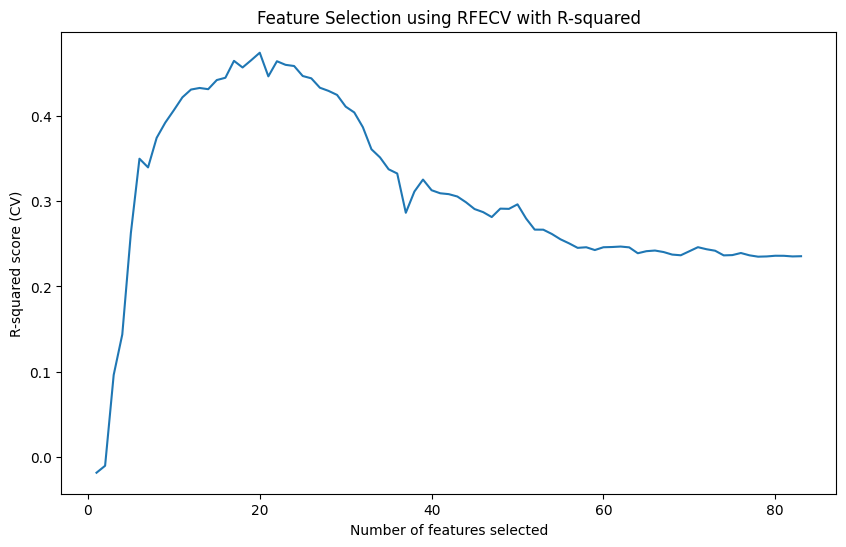

Mean squared error: 47.0735
R-squared score: 0.4665

Coefficients of selected features:
                                              Feature  Coefficient
1   China: Consumer Confidence Index: Employment:P...   -23.893035
3   China: Consumer Expectation Index: Employment:...    14.751914
2   China: Consumer Satisfaction Index: Employment...     9.529242
17     China: Industrial Capacity Utilization:PoP chg     4.703563
14       China: Manufacturing PMI: New Orders:PoP chg    -3.850679
5   China: Retail Sales of the Enterprises (units)...     2.862956
15  China: Completed Investment in Real Estate Dev...    -2.590797
10  China: Non-manufacturing PMI: Service Industry...     2.443107
18              China: Business Climate Index:PoP chg     2.398041
16   China: Index of Future Price Expectation:PoP chg     2.328860
11   China: Non-manufacturing PMI: New Orders:PoP chg    -2.119793
4   China: Total Retail Sales of Consumer Goods: C...    -1.859629
19  China: Business Climate Index: Spot I

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from pathlib import Path
import os

project_dir = Path(os.getcwd()).parent
print(project_dir)

# Navigate upwards and into the data folder (adjust as necessary)
data_dir = project_dir / 'data' / 'data_files' / 'processed_data'

# Load the data
data = pd.read_csv(data_dir / 'em_imputed_stationary.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Fit features and target
X = data.drop('China: GDP: Current Prices:PoP GROWTHRATE', axis=1)
y = data['China: GDP: Current Prices:PoP GROWTHRATE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a LinearRegression estimator
estimator = LinearRegression()

# Create RFECV object
selector = RFECV(estimator, step=1, cv=5, scoring='r2')

# Fit RFECV
selector = selector.fit(X_train_scaled, y_train)

# Get the optimal number of features
n_features_optimal = selector.n_features_

# Get the selected feature mask
feature_mask = selector.support_

# Get the selected feature names
selected_features = X.columns[feature_mask].tolist()

# Print results
print(f"Optimal number of features: {n_features_optimal}")
print(f"Selected features: {selected_features}")

# Plot number of features VS. R-squared score
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.xlabel("Number of features selected")
plt.ylabel("R-squared score (CV)")
plt.title("Feature Selection using RFECV with R-squared")
plt.show()

# Store selected feature names for later reference
selected_feature_names = selected_features

# Use selected features for final model
X_train_selected = X_train_scaled[:, feature_mask]
X_test_selected = X_test_scaled[:, feature_mask]

# Fit final model
final_model = LinearRegression()
final_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = final_model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.4f}")
print(f"R-squared score: {r2:.4f}")

# Display coefficients of selected features
coefficients = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': final_model.coef_
})
print("\nCoefficients of selected features:")
print(coefficients.sort_values(by='Coefficient', key=abs, ascending=False))

# Save selected feature names to a file for future reference
with open('selected_feature_names.txt', 'w') as f:
    for feature in selected_feature_names:
        f.write(f"{feature}\n")

print(f"\nSelected feature names have been saved to 'selected_feature_names.txt'")

In [6]:
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm
from pathlib import Path
import os

project_dir = Path(os.getcwd()).parent
print(project_dir)

# Navigate upwards and into the data folder (adjust as necessary)
data_dir = project_dir / 'data' / 'data_files' / 'processed_data'

# Read data
metadata = pd.read_csv(data_dir / 'meta_monthly_blocks.csv')
data = pd.read_csv(data_dir / 'em_imputed_mq_stationary.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

# Function to standardize a single column
def z_score(x):
    return (x - x.mean()) / x.std()

normalized = data.copy()

normalized.loc[:, normalized.columns != 'date'] = normalized.loc[:, normalized.columns != 'date'].apply(z_score)

data = normalized

target_variable = "China: GDP: Current Prices:PoP GROWTHRATE"

selected_data = pd.DataFrame(data, columns=data.columns)[selected_feature_names]
selected_data['China: GDP: Current Prices:PoP GROWTHRATE'] = data[target_variable]
data = selected_data
print(data.info())

/Users/leyixu/Desktop/Nowcast
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 388 entries, 1992-03-31 to 2024-06-30
Data columns (total 21 columns):
 #   Column                                                                                Non-Null Count  Dtype  
---  ------                                                                                --------------  -----  
 0   China: FAI: YTD:PoP GROWTHRATE                                                        388 non-null    float64
 1   China: Consumer Confidence Index: Employment:PoP chg                                  388 non-null    float64
 2   China: Consumer Satisfaction Index: Employment:PoP chg                                388 non-null    float64
 3   China: Consumer Expectation Index: Employment:PoP chg                                 388 non-null    float64
 4   China: Total Retail Sales of Consumer Goods: Catering Revenue:PoP GROWTHRATE          388 non-null    float64
 5   China: Retail Sales of the Enterpris

In [7]:
print(data.tail())

            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2024-02-29                       -0.433910   
2024-03-31                        0.216944   
2024-04-30                       -1.842809   
2024-05-31                        1.266851   
2024-06-30                        0.472165   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                           0.615044      
2024-03-31                                          -0.436526      
2024-04-30                                          -0.467455      
2024-05-31                                          -0.900454      
2024-06-30                                           0.129715      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                           0.70829

In [6]:
# Create block structure

# Filter metadata to include only series present in the test dataset
filtered_metadata = metadata[metadata['series'].isin(data.columns)]

# Order rows of filtered_metadata to match the order of columns in the test dataset (excluding the first column)
ordered_series = data.columns
filtered_metadata = filtered_metadata.set_index('series').loc[ordered_series]

# Select columns starting with "block_" and drop blocks with no entries
block_columns = [col for col in filtered_metadata.columns if col.startswith('block_')]
blocks = filtered_metadata[block_columns]

# Drop columns with no entries (i.e., sum of the column is zero)
blocks = blocks.loc[:, (blocks.sum(axis=0) > 0)]

# The index of blocks is already the series names, so we don't need to set it again

# Print the resulting blocks DataFrame for debugging
print(blocks)

                                                    block_g1  block_g2  \
China: FAI: YTD:PoP GROWTHRATE                             1         1   
China: Consumer Confidence Index: Employment:Po...         1         1   
China: Consumer Satisfaction Index: Employment:...         1         1   
China: Consumer Expectation Index: Employment:P...         1         1   
China: Total Retail Sales of Consumer Goods: Ca...         1         1   
China: Retail Sales of the Enterprises (units) ...         1         1   
China: Value of Imports and Exports:PoP GROWTHRATE         1         1   
USA: The NASDAQ Composite Index:PoP GROWTHRATE             1         1   
USA: S&P 500 Index:PoP GROWTHRATE                          1         1   
China: M1:PoP GROWTHRATE                                   1         1   
China: Non-manufacturing PMI: Service Industry:...         1         1   
China: Non-manufacturing PMI: New Orders:PoP chg           1         1   
China: Industrial Added Value Above De

In [7]:
# Create testing vintage
import pandas as pd
import numpy as np

# Define date ranges
train_start_date = pd.to_datetime('1992-09-30')
test_start_date = pd.to_datetime("2023-06-30")
test_end_date = pd.to_datetime("2024-06-30")
test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QE')
print(test_dates)

# Replace infinities with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

DatetimeIndex(['2023-06-30', '2023-09-30', '2023-12-31', '2024-03-31',
               '2024-06-30'],
              dtype='datetime64[ns]', freq='QE-DEC')


In [9]:
from pandas.tseries.offsets import MonthEnd
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Initialize DataFrame to store predictions
lags = range(0, 4)
pred_dict = pd.DataFrame({'date': test_dates})
pred_dict['date'] = pd.to_datetime(pred_dict['date'])
for lag in lags:
    pred_dict[str(lag)] = np.nan

# Updated function to generate lagged data
def gen_lagged_data(metadata, data, last_date, lag):
    last_date = pd.Timestamp(last_date)  # Ensure last_date is a Timestamp object
    lagged_data = data.loc[data.index <= last_date, :].reset_index()
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        
        lagged_data.loc[(len(lagged_data) - pub_lag - lag):, col] = np.nan

    return lagged_data


for i, test_date in enumerate(test_dates):
    print(f"Processing test date: {test_date}")
    
    test_date = pd.Timestamp(test_date)
    
    # Train the model using data up to the previous month
    previous_month_end = (test_date - pd.offsets.MonthEnd(1))
    
    print(f"Training data ends at: {previous_month_end}")
    
    train = data.loc[:previous_month_end].copy()
    
    for lag in lags:
        #train = data.loc[:previous_month_end].copy()
        print(f"Processing lag: {lag}")
        lagged_train = gen_lagged_data(metadata, train, previous_month_end, lag)
        lagged_train.set_index('date', inplace=True)
        print(lagged_train.tail())
        
        # Set up the DynamicFactorMQ model
        factor_structure = {series: [] for series in lagged_train.columns}
        for col in blocks.columns:
            for series in blocks.index[blocks[col] == 1]:
                factor_structure[series].append(f'factor_{col}')
        
        print(f"Training on data up to: {previous_month_end}, with lag: {lag}")
        
        model = sm.tsa.DynamicFactorMQ(
            endog=lagged_train,
            k_endog_monthly=16,
            factors=factor_structure,
            factor_orders=12,
            initialization='approximate_diffuse',
            idiosyncratic_ar1=True,
        )
        
        # Fit the model
        results = model.fit(disp=True, method='lbfgs', mstep_method='missing', maxiter=50)
    
        # Use the new data up to the current month for making predictions
        current_month_end = test_date
        
        # Generate lagged data for the current month
        lagged_test = gen_lagged_data(metadata, data, current_month_end, lag)
        lagged_test.set_index('date', inplace=True)
        print(lagged_test.tail())
        
        # Calculate the date for the new information based on the lag and ensure it falls on a month end
        new_info_date = (current_month_end - pd.DateOffset(months=lag)) + pd.offsets.MonthEnd(0)
        print(new_info_date)
        
        # Extract only the row corresponding to the new_info_date
        new_information = lagged_test.loc[:new_info_date]
        print(new_information)
        
        # Make predictions for the current test date using the new data
        prediction = results.predict(start=current_month_end, end=current_month_end, exog=new_information)

        # If prediction is empty or doesn't contain the target variable, use the last available date
        if prediction.empty or "China: GDP: Current Prices:PoP GROWTHRATE" not in prediction.columns:
            last_train_date = train.index[-1]
            prediction = results.predict(start=last_train_date, end=last_train_date, exog=new_information)
            print(prediction)
            print(f"Using last training date for prediction: {last_train_date}")
        
        # Extract the prediction for the target variable
        pred_value = prediction["China: GDP: Current Prices:PoP GROWTHRATE"].iloc[-1]
        
        # Store the prediction in pred_dict for the corresponding lag
        pred_dict.loc[pred_dict['date'] == test_date, str(lag)] = pred_value
        print(results.summary())
        print(pred_dict)

        print(f"Predictions for test date {test_date}:")
        print(pred_dict.loc[pred_dict['date'] == test_date])

print("Final pred_dict:")
print(pred_dict)
        
# Extract actual values for the test period
actuals = data.loc[test_start_date:test_end_date, "China: GDP: Current Prices:PoP GROWTHRATE"].dropna()

# Merge predictions with actuals for performance analysis
predictions_vs_actuals = pd.merge(pred_dict, actuals, left_on='date', right_index=True)

print(predictions_vs_actuals)

Processing test date: 2023-06-30 00:00:00
Training data ends at: 2023-05-31 00:00:00
Processing lag: 0
            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-01-31                        0.193730   
2023-02-28                       -0.245783   
2023-03-31                        0.097074   
2023-04-30                       -2.124363   
2023-05-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-01-31                                           0.955257      
2023-02-28                                           1.604756      
2023-03-31                                          -0.591169      
2023-04-30                                                NaN      
2023-05-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75143D+01    |proj g|=  2.29727D+00

At iterate    1    f=  1.74147D+01    |proj g|=  7.56577D+00

At iterate    2    f=  1.72963D+01    |proj g|=  5.02265D+00

At iterate    3    f=  1.72051D+01    |proj g|=  5.78174D+00

At iterate    4    f=  1.71082D+01    |proj g|=  6.05535D+00

At iterate    5    f=  1.68749D+01    |proj g|=  9.46936D+00

At iterate    6    f=  1.67018D+01    |proj g|=  9.54987D+00

At iterate    7    f=  1.65967D+01    |proj g|=  5.61173D+00

At iterate    8    f=  1.65111D+01    |proj g|=  4.29120D+00

At iterate    9    f=  1.63907D+01    |proj g|=  6.97833D+00

At iterate   10    f=  1.62519D+01    |proj g|=  6.28513D+00

At iterate   11    f=  1.61181D+01    |proj g|=  6.38129D+00

At iterate   12    f=  1.60065D+01    |proj g|=  6.17490D+00

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-02-28                       -0.245783   
2023-03-31                        0.097074   
2023-04-30                       -2.124363   
2023-05-31                        1.697979   
2023-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-02-28                                           1.604756      
2023-03-31                                          -0.591169      
2023-04-30                                          -2.787093      
2023-05-31                                                NaN      
2023-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-02-28                                           1.71124

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73233D+01    |proj g|=  2.05140D+00

At iterate    1    f=  1.72037D+01    |proj g|=  7.98767D+00

At iterate    2    f=  1.70667D+01    |proj g|=  5.64059D+00

At iterate    3    f=  1.69814D+01    |proj g|=  6.49592D+00

At iterate    4    f=  1.68849D+01    |proj g|=  5.66103D+00

At iterate    5    f=  1.68043D+01    |proj g|=  7.40801D+00

At iterate    6    f=  1.65091D+01    |proj g|=  1.63917D+01

At iterate    7    f=  1.63216D+01    |proj g|=  3.61064D+00

At iterate    8    f=  1.62183D+01    |proj g|=  3.85447D+00

At iterate    9    f=  1.60013D+01    |proj g|=  9.71319D+00

At iterate   10    f=  1.58185D+01    |proj g|=  6.22463D+00

At iterate   11    f=  1.55969D+01    |proj g|=  2.36168D+01

At iterate   12    f=  1.52636D+01    |proj g|=  1.09961D+01

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-02-28                       -0.245783   
2023-03-31                        0.097074   
2023-04-30                       -2.124363   
2023-05-31                             NaN   
2023-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-02-28                                           1.604756      
2023-03-31                                          -0.591169      
2023-04-30                                                NaN      
2023-05-31                                                NaN      
2023-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-02-28                                           1.71124

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74857D+01    |proj g|=  1.89921D+00


 This problem is unconstrained.



At iterate    1    f=  1.73934D+01    |proj g|=  7.47285D+00

At iterate    2    f=  1.72768D+01    |proj g|=  5.56485D+00

At iterate    3    f=  1.71416D+01    |proj g|=  6.32860D+00

At iterate    4    f=  1.69959D+01    |proj g|=  5.77001D+00

At iterate    5    f=  1.66853D+01    |proj g|=  4.80596D+00

At iterate    6    f=  1.64744D+01    |proj g|=  3.46986D+00

At iterate    7    f=  1.63716D+01    |proj g|=  1.14073D+01

At iterate    8    f=  1.62261D+01    |proj g|=  9.16515D+00

At iterate    9    f=  1.61319D+01    |proj g|=  3.28641D+00

At iterate   10    f=  1.60183D+01    |proj g|=  8.57840D+00

At iterate   11    f=  1.58673D+01    |proj g|=  1.23219D+01

At iterate   12    f=  1.56312D+01    |proj g|=  1.43225D+01

At iterate   13    f=  1.50143D+01    |proj g|=  2.05035D+01

At iterate   14    f=  1.49012D+01    |proj g|=  6.25726D+01

At iterate   15    f=  1.47708D+01    |proj g|=  4.03616D+01

At iterate   16    f=  1.46956D+01    |proj g|=  5.77565D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-02-28                       -0.245783   
2023-03-31                        0.097074   
2023-04-30                             NaN   
2023-05-31                             NaN   
2023-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-02-28                                           1.604756      
2023-03-31                                                NaN      
2023-04-30                                                NaN      
2023-05-31                                                NaN      
2023-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-02-28                                           1.71124

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72298D+01    |proj g|=  1.87494D+00


 This problem is unconstrained.



At iterate    1    f=  1.71328D+01    |proj g|=  8.62805D+00

At iterate    2    f=  1.70051D+01    |proj g|=  5.29819D+00

At iterate    3    f=  1.68355D+01    |proj g|=  5.34888D+00

At iterate    4    f=  1.66761D+01    |proj g|=  5.09070D+00

At iterate    5    f=  1.65143D+01    |proj g|=  7.12429D+00

At iterate    6    f=  1.63496D+01    |proj g|=  6.73977D+00

At iterate    7    f=  1.61595D+01    |proj g|=  7.49263D+00

At iterate    8    f=  1.59198D+01    |proj g|=  1.45568D+01

At iterate    9    f=  1.57894D+01    |proj g|=  1.13060D+01

At iterate   10    f=  1.56784D+01    |proj g|=  1.78283D+01

At iterate   11    f=  1.55472D+01    |proj g|=  8.02256D+00

At iterate   12    f=  1.52208D+01    |proj g|=  3.54847D+01

At iterate   13    f=  1.50422D+01    |proj g|=  3.61840D+01

At iterate   14    f=  1.48887D+01    |proj g|=  3.18657D+01

At iterate   15    f=  1.48035D+01    |proj g|=  2.88105D+01

At iterate   16    f=  1.46129D+01    |proj g|=  2.69196D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-02-28                       -0.245783   
2023-03-31                             NaN   
2023-04-30                             NaN   
2023-05-31                             NaN   
2023-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-02-28                                                NaN      
2023-03-31                                                NaN      
2023-04-30                                                NaN      
2023-05-31                                                NaN      
2023-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-02-28                                                Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75298D+01    |proj g|=  2.29497D+00

At iterate    1    f=  1.74369D+01    |proj g|=  8.43971D+00

At iterate    2    f=  1.73157D+01    |proj g|=  4.92405D+00

At iterate    3    f=  1.72271D+01    |proj g|=  4.99081D+00

At iterate    4    f=  1.71496D+01    |proj g|=  5.97496D+00

At iterate    5    f=  1.68830D+01    |proj g|=  1.43812D+01

At iterate    6    f=  1.67528D+01    |proj g|=  8.05317D+00

At iterate    7    f=  1.66128D+01    |proj g|=  3.83173D+00

At iterate    8    f=  1.64730D+01    |proj g|=  3.92427D+00

At iterate    9    f=  1.63471D+01    |proj g|=  9.50030D+00

At iterate   10    f=  1.62352D+01    |proj g|=  7.57081D+00

At iterate   11    f=  1.61630D+01    |proj g|=  2.94200D+00

At iterate   12    f=  1.61029D+01    |proj g|=  4.42203D+00

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-05-31                        1.697979   
2023-06-30                        0.428202   
2023-07-31                       -0.536405   
2023-08-31                        0.350878   
2023-09-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                          -0.158169      
2023-06-30                                          -0.869525      
2023-07-31                                          -0.158169      
2023-08-31                                                NaN      
2023-09-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-05-31                                          -0.22993

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74526D+01    |proj g|=  2.30024D+00


 This problem is unconstrained.



At iterate    1    f=  1.73632D+01    |proj g|=  8.05949D+00

At iterate    2    f=  1.72473D+01    |proj g|=  4.94082D+00

At iterate    3    f=  1.71595D+01    |proj g|=  5.11156D+00

At iterate    4    f=  1.70863D+01    |proj g|=  5.91302D+00

At iterate    5    f=  1.68202D+01    |proj g|=  1.07427D+01

At iterate    6    f=  1.66732D+01    |proj g|=  6.02413D+00

At iterate    7    f=  1.65226D+01    |proj g|=  4.64860D+00

At iterate    8    f=  1.63681D+01    |proj g|=  5.50802D+00

At iterate    9    f=  1.62746D+01    |proj g|=  3.00050D+00

At iterate   10    f=  1.62133D+01    |proj g|=  1.19425D+01

At iterate   11    f=  1.61124D+01    |proj g|=  2.55348D+00

At iterate   12    f=  1.60641D+01    |proj g|=  3.41040D+00

At iterate   13    f=  1.60144D+01    |proj g|=  5.14097D+00

At iterate   14    f=  1.59718D+01    |proj g|=  1.56959D+01

At iterate   15    f=  1.58175D+01    |proj g|=  9.22623D+00

At iterate   16    f=  1.56655D+01    |proj g|=  8.98699D+00

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-05-31                        1.697979   
2023-06-30                        0.428202   
2023-07-31                       -0.536405   
2023-08-31                             NaN   
2023-09-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                          -0.158169      
2023-06-30                                          -0.869525      
2023-07-31                                                NaN      
2023-08-31                                                NaN      
2023-09-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-05-31                                          -0.22993

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74549D+01    |proj g|=  1.88273D+00


 This problem is unconstrained.



At iterate    1    f=  1.73708D+01    |proj g|=  7.12793D+00

At iterate    2    f=  1.72539D+01    |proj g|=  6.09783D+00

At iterate    3    f=  1.71236D+01    |proj g|=  7.02531D+00

At iterate    4    f=  1.69502D+01    |proj g|=  5.64338D+00

At iterate    5    f=  1.66630D+01    |proj g|=  7.29298D+00

At iterate    6    f=  1.64852D+01    |proj g|=  5.55003D+00

At iterate    7    f=  1.64167D+01    |proj g|=  3.26030D+00

At iterate    8    f=  1.62944D+01    |proj g|=  2.29650D+00

At iterate    9    f=  1.61332D+01    |proj g|=  2.32518D+00

At iterate   10    f=  1.60095D+01    |proj g|=  2.24590D+00

At iterate   11    f=  1.56963D+01    |proj g|=  4.66474D+00

At iterate   12    f=  1.54825D+01    |proj g|=  1.85066D+01

At iterate   13    f=  1.53072D+01    |proj g|=  1.24930D+01

At iterate   14    f=  1.52116D+01    |proj g|=  1.48913D+01

At iterate   15    f=  1.50255D+01    |proj g|=  2.20709D+01

At iterate   16    f=  1.48605D+01    |proj g|=  5.51959D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-05-31                        1.697979   
2023-06-30                        0.428202   
2023-07-31                             NaN   
2023-08-31                             NaN   
2023-09-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                          -0.158169      
2023-06-30                                                NaN      
2023-07-31                                                NaN      
2023-08-31                                                NaN      
2023-09-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-05-31                                          -0.22993

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74370D+01    |proj g|=  2.10436D+00

At iterate    1    f=  1.73452D+01    |proj g|=  6.84545D+00

At iterate    2    f=  1.72307D+01    |proj g|=  5.69351D+00

At iterate    3    f=  1.71255D+01    |proj g|=  7.31480D+00

At iterate    4    f=  1.70159D+01    |proj g|=  5.78252D+00

At iterate    5    f=  1.66952D+01    |proj g|=  3.89118D+00

At iterate    6    f=  1.65385D+01    |proj g|=  6.51149D+00

At iterate    7    f=  1.64292D+01    |proj g|=  4.02987D+00

At iterate    8    f=  1.63233D+01    |proj g|=  6.01633D+00

At iterate    9    f=  1.62028D+01    |proj g|=  3.38009D+00

At iterate   10    f=  1.61010D+01    |proj g|=  3.34373D+00

At iterate   11    f=  1.60084D+01    |proj g|=  1.10286D+01

At iterate   12    f=  1.58666D+01    |proj g|=  4.19007D+00

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-05-31                        1.697979   
2023-06-30                             NaN   
2023-07-31                             NaN   
2023-08-31                             NaN   
2023-09-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                                NaN      
2023-06-30                                                NaN      
2023-07-31                                                NaN      
2023-08-31                                                NaN      
2023-09-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-05-31                                                Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75103D+01    |proj g|=  2.27666D+00


 This problem is unconstrained.



At iterate    1    f=  1.74209D+01    |proj g|=  8.94813D+00

At iterate    2    f=  1.72959D+01    |proj g|=  4.85244D+00

At iterate    3    f=  1.72075D+01    |proj g|=  4.90692D+00

At iterate    4    f=  1.71368D+01    |proj g|=  5.82788D+00

At iterate    5    f=  1.68918D+01    |proj g|=  9.57284D+00

At iterate    6    f=  1.67306D+01    |proj g|=  5.55202D+00

At iterate    7    f=  1.66362D+01    |proj g|=  5.53488D+00

At iterate    8    f=  1.64276D+01    |proj g|=  3.21764D+00

At iterate    9    f=  1.62763D+01    |proj g|=  6.72091D+00

At iterate   10    f=  1.61012D+01    |proj g|=  3.03097D+00

At iterate   11    f=  1.60227D+01    |proj g|=  9.60307D+00

At iterate   12    f=  1.59068D+01    |proj g|=  7.00610D+00

At iterate   13    f=  1.57494D+01    |proj g|=  7.93951D+00

At iterate   14    f=  1.55588D+01    |proj g|=  1.62833D+01

At iterate   15    f=  1.52667D+01    |proj g|=  1.22357D+02

At iterate   16    f=  1.50353D+01    |proj g|=  8.89924D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-08-31                        0.350878   
2023-09-30                        0.167888   
2023-10-31                       -0.153485   
2023-11-30                        0.041438   
2023-12-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-08-31                                           0.151116      
2023-09-30                                           0.707829      
2023-10-31                                           0.058330      
2023-11-30                                                NaN      
2023-12-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-08-31                                           0.15829

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74994D+01    |proj g|=  2.27542D+00

At iterate    1    f=  1.74115D+01    |proj g|=  8.45936D+00

At iterate    2    f=  1.72926D+01    |proj g|=  4.91379D+00

At iterate    3    f=  1.72018D+01    |proj g|=  4.91563D+00

At iterate    4    f=  1.71315D+01    |proj g|=  5.97273D+00

At iterate    5    f=  1.68405D+01    |proj g|=  8.59001D+00

At iterate    6    f=  1.66776D+01    |proj g|=  6.04178D+00

At iterate    7    f=  1.65649D+01    |proj g|=  4.17461D+00

At iterate    8    f=  1.64005D+01    |proj g|=  3.95971D+00

At iterate    9    f=  1.63151D+01    |proj g|=  2.40614D+00

At iterate   10    f=  1.61867D+01    |proj g|=  3.49407D+00

At iterate   11    f=  1.61014D+01    |proj g|=  6.42662D+00

At iterate   12    f=  1.60181D+01    |proj g|=  3.71731D+00

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-08-31                        0.350878   
2023-09-30                        0.167888   
2023-10-31                       -0.153485   
2023-11-30                             NaN   
2023-12-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-08-31                                           0.151116      
2023-09-30                                           0.707829      
2023-10-31                                                NaN      
2023-11-30                                                NaN      
2023-12-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-08-31                                           0.15829

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74416D+01    |proj g|=  2.27577D+00

At iterate    1    f=  1.73504D+01    |proj g|=  8.24635D+00

At iterate    2    f=  1.72316D+01    |proj g|=  5.04786D+00

At iterate    3    f=  1.71393D+01    |proj g|=  5.24815D+00

At iterate    4    f=  1.70626D+01    |proj g|=  6.05389D+00

At iterate    5    f=  1.67301D+01    |proj g|=  1.13046D+01

At iterate    6    f=  1.66954D+01    |proj g|=  1.29761D+01

At iterate    7    f=  1.65043D+01    |proj g|=  3.84714D+00

At iterate    8    f=  1.64241D+01    |proj g|=  3.50860D+00

At iterate    9    f=  1.62761D+01    |proj g|=  7.73117D+00

At iterate   10    f=  1.61742D+01    |proj g|=  4.43577D+00

At iterate   11    f=  1.61248D+01    |proj g|=  7.41975D+00

At iterate   12    f=  1.60012D+01    |proj g|=  4.63925D+00

At iterate   13    f=  1.5


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-08-31                        0.350878   
2023-09-30                        0.167888   
2023-10-31                             NaN   
2023-11-30                             NaN   
2023-12-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-08-31                                           0.151116      
2023-09-30                                                NaN      
2023-10-31                                                NaN      
2023-11-30                                                NaN      
2023-12-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-08-31                                           0.15829

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73696D+01    |proj g|=  2.26074D+00

At iterate    1    f=  1.72795D+01    |proj g|=  8.46444D+00

At iterate    2    f=  1.71586D+01    |proj g|=  4.83338D+00

At iterate    3    f=  1.70719D+01    |proj g|=  4.77499D+00

At iterate    4    f=  1.69972D+01    |proj g|=  5.75056D+00

At iterate    5    f=  1.67626D+01    |proj g|=  1.38615D+01

At iterate    6    f=  1.66905D+01    |proj g|=  8.71082D+00

At iterate    7    f=  1.65119D+01    |proj g|=  3.92885D+00

At iterate    8    f=  1.63631D+01    |proj g|=  5.15155D+00

At iterate    9    f=  1.62204D+01    |proj g|=  2.96179D+00

At iterate   10    f=  1.60600D+01    |proj g|=  5.87494D+00

At iterate   11    f=  1.60050D+01    |proj g|=  4.98912D+00

At iterate   12    f=  1.59323D+01    |proj g|=  2.34145D+00

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-08-31                        0.350878   
2023-09-30                             NaN   
2023-10-31                             NaN   
2023-11-30                             NaN   
2023-12-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-08-31                                                NaN      
2023-09-30                                                NaN      
2023-10-31                                                NaN      
2023-11-30                                                NaN      
2023-12-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-08-31                                                Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75334D+01    |proj g|=  2.24964D+00

At iterate    1    f=  1.74418D+01    |proj g|=  8.83886D+00

At iterate    2    f=  1.73186D+01    |proj g|=  4.77730D+00

At iterate    3    f=  1.72321D+01    |proj g|=  4.61668D+00

At iterate    4    f=  1.71575D+01    |proj g|=  5.56730D+00

At iterate    5    f=  1.69452D+01    |proj g|=  1.15307D+01

At iterate    6    f=  1.67915D+01    |proj g|=  5.93043D+00

At iterate    7    f=  1.66759D+01    |proj g|=  4.32571D+00

At iterate    8    f=  1.65260D+01    |proj g|=  3.81535D+00

At iterate    9    f=  1.63749D+01    |proj g|=  8.21633D+00

At iterate   10    f=  1.62980D+01    |proj g|=  1.08626D+01

At iterate   11    f=  1.61883D+01    |proj g|=  3.16179D+00

At iterate   12    f=  1.61453D+01    |proj g|=  2.08804D+00

At iterate   13    f=  1.6

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-11-30                        0.041438   
2023-12-31                        0.062456   
2024-01-31                        0.332646   
2024-02-29                       -0.433910   
2024-03-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-11-30                                          -0.250955      
2023-12-31                                           0.089259      
2024-01-31                                           0.212973      
2024-02-29                                                NaN      
2024-03-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-11-30                                          -0.39170

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74205D+01    |proj g|=  2.24344D+00


 This problem is unconstrained.



At iterate    1    f=  1.73299D+01    |proj g|=  9.48042D+00

At iterate    2    f=  1.71938D+01    |proj g|=  4.90271D+00

At iterate    3    f=  1.70966D+01    |proj g|=  4.75994D+00

At iterate    4    f=  1.70065D+01    |proj g|=  5.62853D+00

At iterate    5    f=  1.67632D+01    |proj g|=  5.69540D+00

At iterate    6    f=  1.65910D+01    |proj g|=  5.04283D+00

At iterate    7    f=  1.62987D+01    |proj g|=  1.42858D+01

At iterate    8    f=  1.61136D+01    |proj g|=  5.97912D+00

At iterate    9    f=  1.60198D+01    |proj g|=  6.01628D+00

At iterate   10    f=  1.58159D+01    |proj g|=  7.35430D+00

At iterate   11    f=  1.54770D+01    |proj g|=  4.93616D+01

At iterate   12    f=  1.49369D+01    |proj g|=  6.23603D+01

At iterate   13    f=  1.48010D+01    |proj g|=  4.67852D+01

At iterate   14    f=  1.45661D+01    |proj g|=  8.50600D+01

At iterate   15    f=  1.45292D+01    |proj g|=  7.55627D+01

At iterate   16    f=  1.44332D+01    |proj g|=  3.18304D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-11-30                        0.041438   
2023-12-31                        0.062456   
2024-01-31                        0.332646   
2024-02-29                             NaN   
2024-03-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-11-30                                          -0.250955      
2023-12-31                                           0.089259      
2024-01-31                                                NaN      
2024-02-29                                                NaN      
2024-03-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-11-30                                          -0.39170

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74660D+01    |proj g|=  2.20267D+00

At iterate    1    f=  1.73786D+01    |proj g|=  8.08135D+00

At iterate    2    f=  1.72634D+01    |proj g|=  5.12014D+00

At iterate    3    f=  1.71644D+01    |proj g|=  5.36271D+00

At iterate    4    f=  1.70883D+01    |proj g|=  6.00028D+00

At iterate    5    f=  1.67047D+01    |proj g|=  7.72386D+00

At iterate    6    f=  1.65836D+01    |proj g|=  4.62024D+00

At iterate    7    f=  1.65015D+01    |proj g|=  3.90119D+00

At iterate    8    f=  1.63672D+01    |proj g|=  2.76421D+00

At iterate    9    f=  1.62060D+01    |proj g|=  3.98264D+00

At iterate   10    f=  1.60358D+01    |proj g|=  6.80299D+00

At iterate   11    f=  1.59820D+01    |proj g|=  7.13540D+00

At iterate   12    f=  1.58898D+01    |proj g|=  3.63564D+00

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-11-30                        0.041438   
2023-12-31                        0.062456   
2024-01-31                             NaN   
2024-02-29                             NaN   
2024-03-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-11-30                                          -0.250955      
2023-12-31                                                NaN      
2024-01-31                                                NaN      
2024-02-29                                                NaN      
2024-03-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-11-30                                          -0.39170

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73418D+01    |proj g|=  2.26209D+00


 This problem is unconstrained.



At iterate    1    f=  1.72516D+01    |proj g|=  8.91602D+00

At iterate    2    f=  1.71267D+01    |proj g|=  5.00059D+00

At iterate    3    f=  1.70360D+01    |proj g|=  4.91832D+00

At iterate    4    f=  1.69638D+01    |proj g|=  5.93643D+00

At iterate    5    f=  1.67034D+01    |proj g|=  8.49699D+00

At iterate    6    f=  1.65787D+01    |proj g|=  5.20316D+00

At iterate    7    f=  1.64560D+01    |proj g|=  4.62489D+00

At iterate    8    f=  1.62753D+01    |proj g|=  5.00516D+00

At iterate    9    f=  1.61288D+01    |proj g|=  2.04547D+00

At iterate   10    f=  1.59866D+01    |proj g|=  3.76334D+00

At iterate   11    f=  1.59381D+01    |proj g|=  4.92497D+00

At iterate   12    f=  1.58777D+01    |proj g|=  2.31229D+00

At iterate   13    f=  1.57564D+01    |proj g|=  3.18227D+00

At iterate   14    f=  1.56108D+01    |proj g|=  8.25186D+00

At iterate   15    f=  1.54120D+01    |proj g|=  3.21616D+01

At iterate   16    f=  1.51787D+01    |proj g|=  2.10080D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2023-11-30                        0.041438   
2023-12-31                             NaN   
2024-01-31                             NaN   
2024-02-29                             NaN   
2024-03-31                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-11-30                                                NaN      
2023-12-31                                                NaN      
2024-01-31                                                NaN      
2024-02-29                                                NaN      
2024-03-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-11-30                                                Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75600D+01    |proj g|=  2.21543D+00


 This problem is unconstrained.



At iterate    1    f=  1.74718D+01    |proj g|=  8.69861D+00

At iterate    2    f=  1.73541D+01    |proj g|=  4.64378D+00

At iterate    3    f=  1.72675D+01    |proj g|=  4.64745D+00

At iterate    4    f=  1.71949D+01    |proj g|=  5.60093D+00

At iterate    5    f=  1.69938D+01    |proj g|=  1.12249D+01

At iterate    6    f=  1.67924D+01    |proj g|=  4.60030D+00

At iterate    7    f=  1.67096D+01    |proj g|=  4.38887D+00

At iterate    8    f=  1.64452D+01    |proj g|=  6.59292D+00

At iterate    9    f=  1.63144D+01    |proj g|=  1.15228D+01

At iterate   10    f=  1.62214D+01    |proj g|=  2.89201D+00

At iterate   11    f=  1.61753D+01    |proj g|=  2.43505D+00

At iterate   12    f=  1.61087D+01    |proj g|=  4.05743D+00

At iterate   13    f=  1.59760D+01    |proj g|=  7.18624D+00

At iterate   14    f=  1.57748D+01    |proj g|=  9.38079D+00

At iterate   15    f=  1.54925D+01    |proj g|=  2.12756D+01

At iterate   16    f=  1.53044D+01    |proj g|=  2.20955D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2024-02-29                       -0.433910   
2024-03-31                        0.216944   
2024-04-30                       -1.842809   
2024-05-31                        1.266851   
2024-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                           0.615044      
2024-03-31                                          -0.436526      
2024-04-30                                          -0.467455      
2024-05-31                                                NaN      
2024-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                           0.70829

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74670D+01    |proj g|=  2.13852D+00

At iterate    1    f=  1.73798D+01    |proj g|=  9.00780D+00

At iterate    2    f=  1.72569D+01    |proj g|=  4.41139D+00

At iterate    3    f=  1.71649D+01    |proj g|=  4.81869D+00

At iterate    4    f=  1.70831D+01    |proj g|=  5.31358D+00

At iterate    5    f=  1.68917D+01    |proj g|=  5.70420D+00

At iterate    6    f=  1.66178D+01    |proj g|=  7.06591D+00

At iterate    7    f=  1.64661D+01    |proj g|=  6.88720D+00

At iterate    8    f=  1.63560D+01    |proj g|=  1.14922D+01

At iterate    9    f=  1.61988D+01    |proj g|=  5.77709D+00

At iterate   10    f=  1.61076D+01    |proj g|=  4.83363D+00

At iterate   11    f=  1.58419D+01    |proj g|=  1.39638D+01

At iterate   12    f=  1.55357D+01    |proj g|=  1.44696D+01

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2024-02-29                       -0.433910   
2024-03-31                        0.216944   
2024-04-30                       -1.842809   
2024-05-31                             NaN   
2024-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                           0.615044      
2024-03-31                                          -0.436526      
2024-04-30                                                NaN      
2024-05-31                                                NaN      
2024-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                           0.70829

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75428D+01    |proj g|=  2.17812D+00

At iterate    1    f=  1.74535D+01    |proj g|=  7.95406D+00

At iterate    2    f=  1.73423D+01    |proj g|=  4.92887D+00

At iterate    3    f=  1.72462D+01    |proj g|=  5.09823D+00

At iterate    4    f=  1.71612D+01    |proj g|=  5.81111D+00

At iterate    5    f=  1.69557D+01    |proj g|=  1.25326D+01

At iterate    6    f=  1.67562D+01    |proj g|=  7.73201D+00

At iterate    7    f=  1.66077D+01    |proj g|=  3.90604D+00

At iterate    8    f=  1.64899D+01    |proj g|=  3.87057D+00

At iterate    9    f=  1.63729D+01    |proj g|=  2.76908D+00

At iterate   10    f=  1.62563D+01    |proj g|=  1.09328D+01

At iterate   11    f=  1.61907D+01    |proj g|=  5.34409D+00

At iterate   12    f=  1.61490D+01    |proj g|=  3.48169D+00

At iterate   13    f=  1.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2024-02-29                       -0.433910   
2024-03-31                        0.216944   
2024-04-30                             NaN   
2024-05-31                             NaN   
2024-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                           0.615044      
2024-03-31                                                NaN      
2024-04-30                                                NaN      
2024-05-31                                                NaN      
2024-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                           0.70829

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          242     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74403D+01    |proj g|=  2.23286D+00

At iterate    1    f=  1.73474D+01    |proj g|=  8.17684D+00

At iterate    2    f=  1.72308D+01    |proj g|=  5.04746D+00

At iterate    3    f=  1.71428D+01    |proj g|=  5.28527D+00

At iterate    4    f=  1.70624D+01    |proj g|=  5.83043D+00

At iterate    5    f=  1.69105D+01    |proj g|=  1.23847D+01

At iterate    6    f=  1.66104D+01    |proj g|=  4.79522D+00

At iterate    7    f=  1.65090D+01    |proj g|=  4.59791D+00

At iterate    8    f=  1.63662D+01    |proj g|=  4.63184D+00

At iterate    9    f=  1.62515D+01    |proj g|=  2.25406D+00

At iterate   10    f=  1.60903D+01    |proj g|=  6.51536D+00

At iterate   11    f=  1.59940D+01    |proj g|=  6.88545D+00

At iterate   12    f=  1.59023D+01    |proj g|=  4.33648D+00

At iterate   13    f=  1.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2024-02-29                        -0.43391   
2024-03-31                             NaN   
2024-04-30                             NaN   
2024-05-31                             NaN   
2024-06-30                             NaN   

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                                NaN      
2024-03-31                                                NaN      
2024-04-30                                                NaN      
2024-05-31                                                NaN      
2024-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                                Na

In [10]:
# Extract actual values for the test period
actuals = data.loc[test_start_date:test_end_date, "China: GDP: Current Prices:PoP GROWTHRATE"]

# Merge predictions with actuals for performance analysis
predictions_vs_actuals = pd.merge(pred_dict, actuals, left_on='date', right_index=True)

print(predictions_vs_actuals)

actuals = actuals.reset_index().dropna()  # Reset the index and drop the old index

actuals.columns = ['date', 'value']  # Adjust column names

        date         0         1         2         3  \
0 2023-06-30  0.597336  0.867458  0.728501  0.081868   
1 2023-09-30  0.296425  0.141246  0.452095  0.419025   
2 2023-12-31  0.433476  0.254351  0.078387  1.051687   
3 2024-03-31 -0.558844 -0.485995 -0.770238 -0.760855   
4 2024-06-30  0.339738  0.305963  0.052943  0.323526   

   China: GDP: Current Prices:PoP GROWTHRATE  
0                                   0.384809  
1                                   0.043899  
2                                   0.408796  
3                                  -1.509544  
4                                   0.369399  


RMSE for lag 0: 0.4519


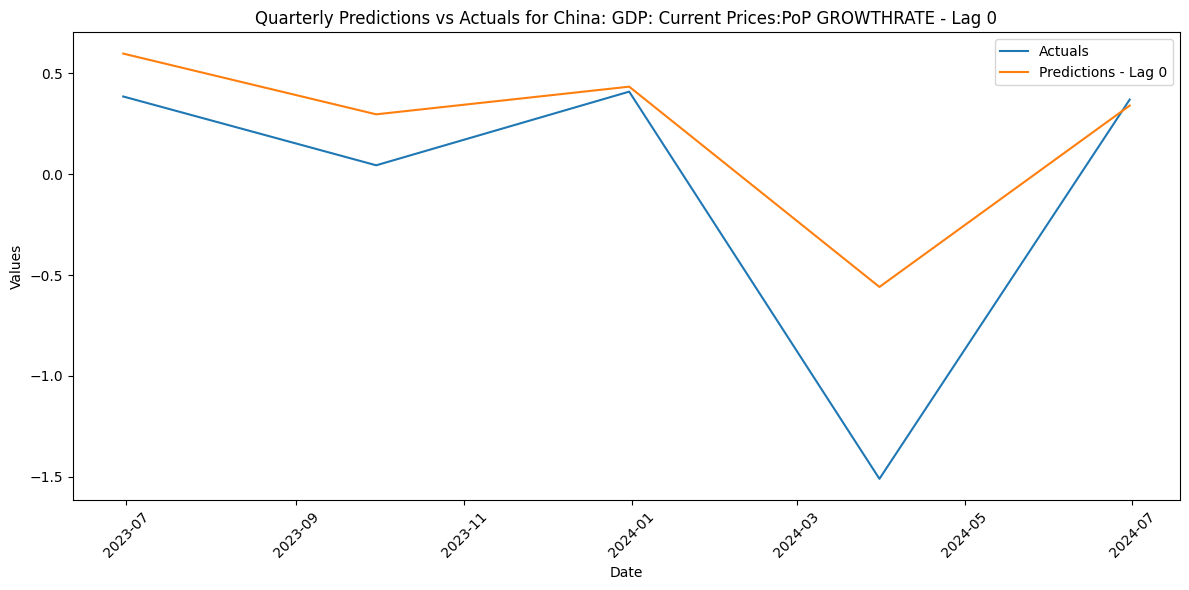

RMSE for lag 1: 0.5068


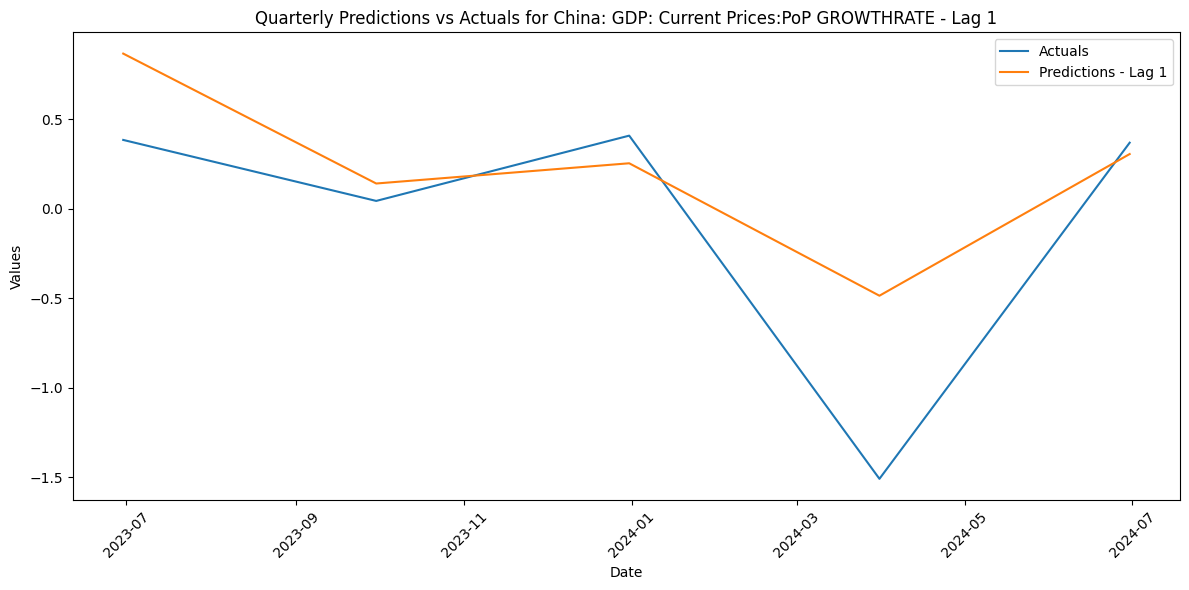

RMSE for lag 2: 0.6249


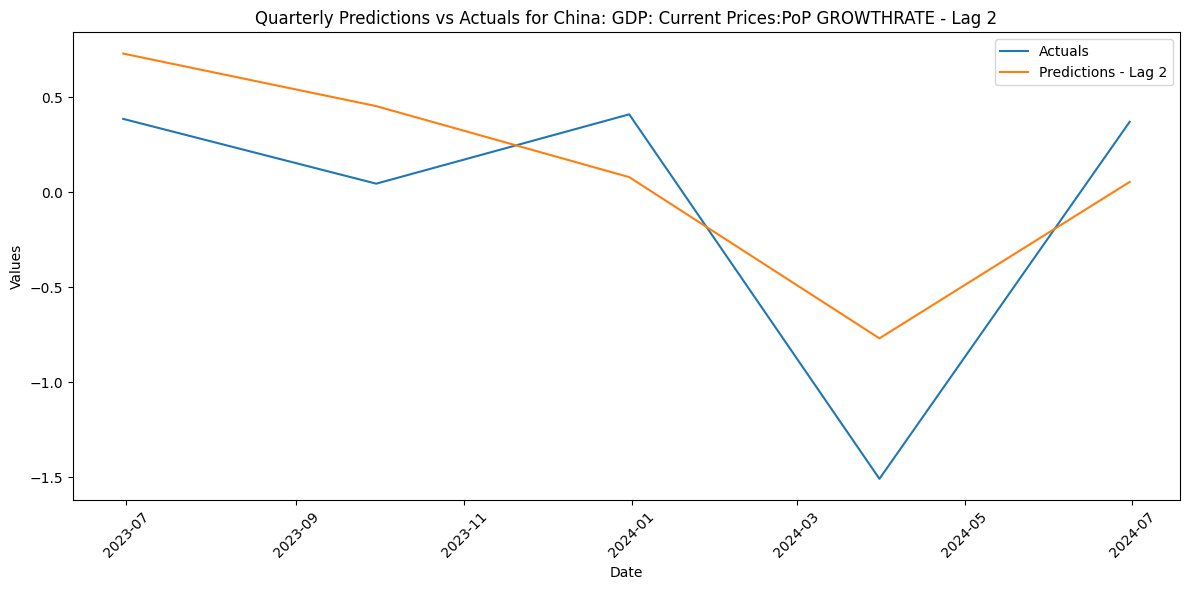

RMSE for lag 3: 0.6080


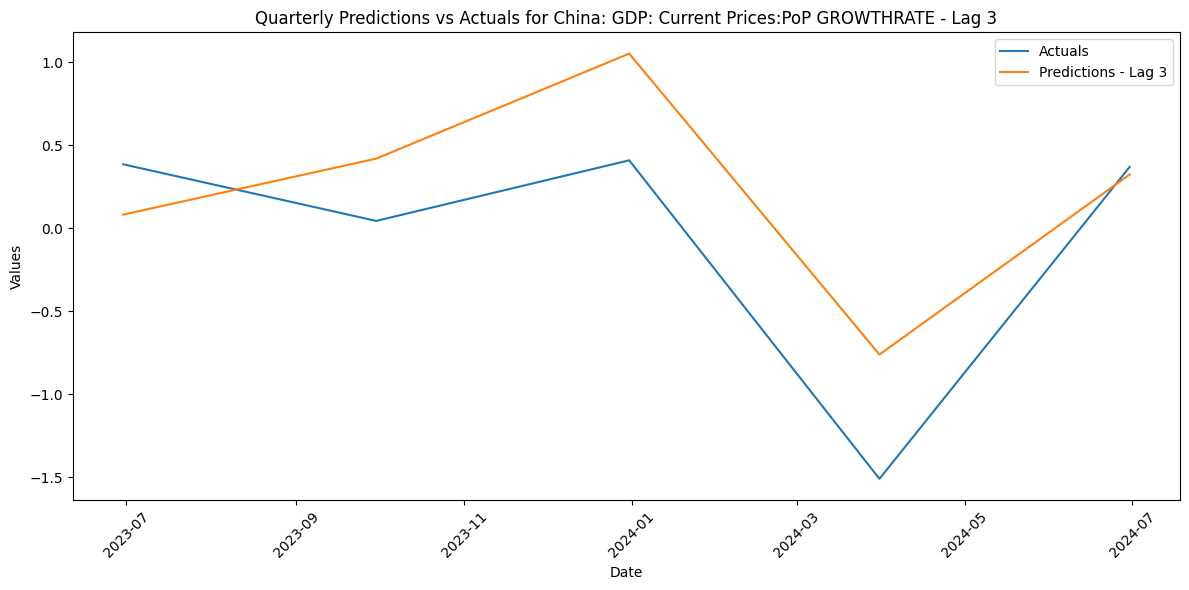

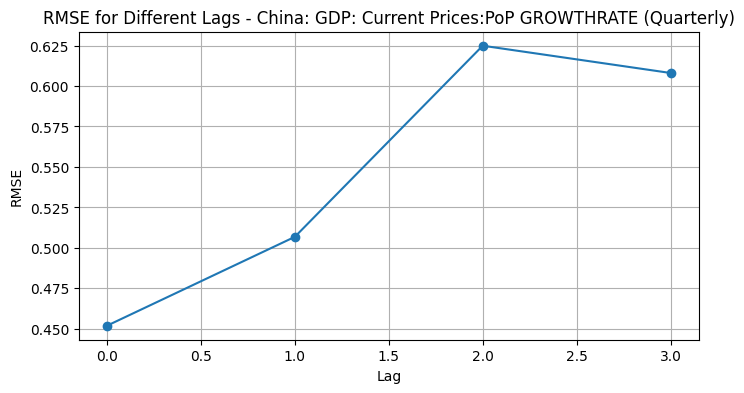

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize DataFrame to store RMSE for each lag
rmse_dict = {}

# Loop through lags and calculate RMSE, prepare for plotting
for lag in lags:
    # Extract the predictions for the current lag
    predictions = pred_dict[['date', str(lag)]].copy()
    predictions.columns = ['date', 'value']
    
    # Ensure predictions are quarterly
    predictions['quarter'] = pd.to_datetime(predictions['date']).dt.to_period('Q')
    quarterly_pred = predictions.groupby('quarter').first().reset_index()
    
    # Prepare actuals (assuming they're already quarterly)
    actuals['quarter'] = pd.to_datetime(actuals['date']).dt.to_period('Q')
    
    # Ensure the quarters of both series match
    common_quarters = set(quarterly_pred['quarter']) & set(actuals['quarter'])
    quarterly_pred = quarterly_pred[quarterly_pred['quarter'].isin(common_quarters)]
    quarterly_actuals = actuals[actuals['quarter'].isin(common_quarters)]
    
    # Calculate RMSE for this lag
    rmse = np.sqrt(np.mean((quarterly_actuals['value'] - quarterly_pred['value'])**2))
    rmse_dict[lag] = rmse
    print(f"RMSE for lag {lag}: {rmse:.4f}")
    
    # Prepare the data for plotting
    plot_data = pd.DataFrame({
        'date': quarterly_actuals['date'],
        'actuals': quarterly_actuals['value'].values,
        f'predictions_lag_{lag}': quarterly_pred['value'].values
    })
    
    # Plot predictions vs actuals for this lag
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_data, x='date', y='actuals', label='Actuals')
    sns.lineplot(data=plot_data, x='date', y=f'predictions_lag_{lag}', label=f'Predictions - Lag {lag}')
    plt.title(f"Quarterly Predictions vs Actuals for {target_variable} - Lag {lag}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot RMSE for each lag
plt.figure(figsize=(8, 4))
plt.plot(list(rmse_dict.keys()), list(rmse_dict.values()), marker='o')
plt.title(f"RMSE for Different Lags - {target_variable} (Quarterly)")
plt.xlabel("Lag")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

In [ ]:
# Save predictions to CSV (actual result used for ensemble covers the full test period, this is only for illustration purpose)
csv_filename = 'dfm_mq.csv'
predictions.to_csv(project_dir / 'results' / csv_filename, index=False)
print(f"Predictions data saved to {csv_filename}")

csv_filename = 'actuals_deseason.csv'
actuals.to_csv(project_dir / 'results' / csv_filename, index=False)
print(f"Predictions data saved to {csv_filename}")